In [7]:
from IPython.display import Image

## 0. What are we doing and why?

In general, we are building a map from sensors on an autopiloted car. In detail, we are making a plugin to integrate it with existing approaches to improve them. The idea of the plugin is to store the maps we have already built, organized in one global map, to use them as a prior for building new local maps.

This is not the first architecture to use history as a prior. Another one is mentioned in the article itself --- the BEVFormer. Here it is (sect 2.2 in https://arxiv.org/pdf/2203.17270)


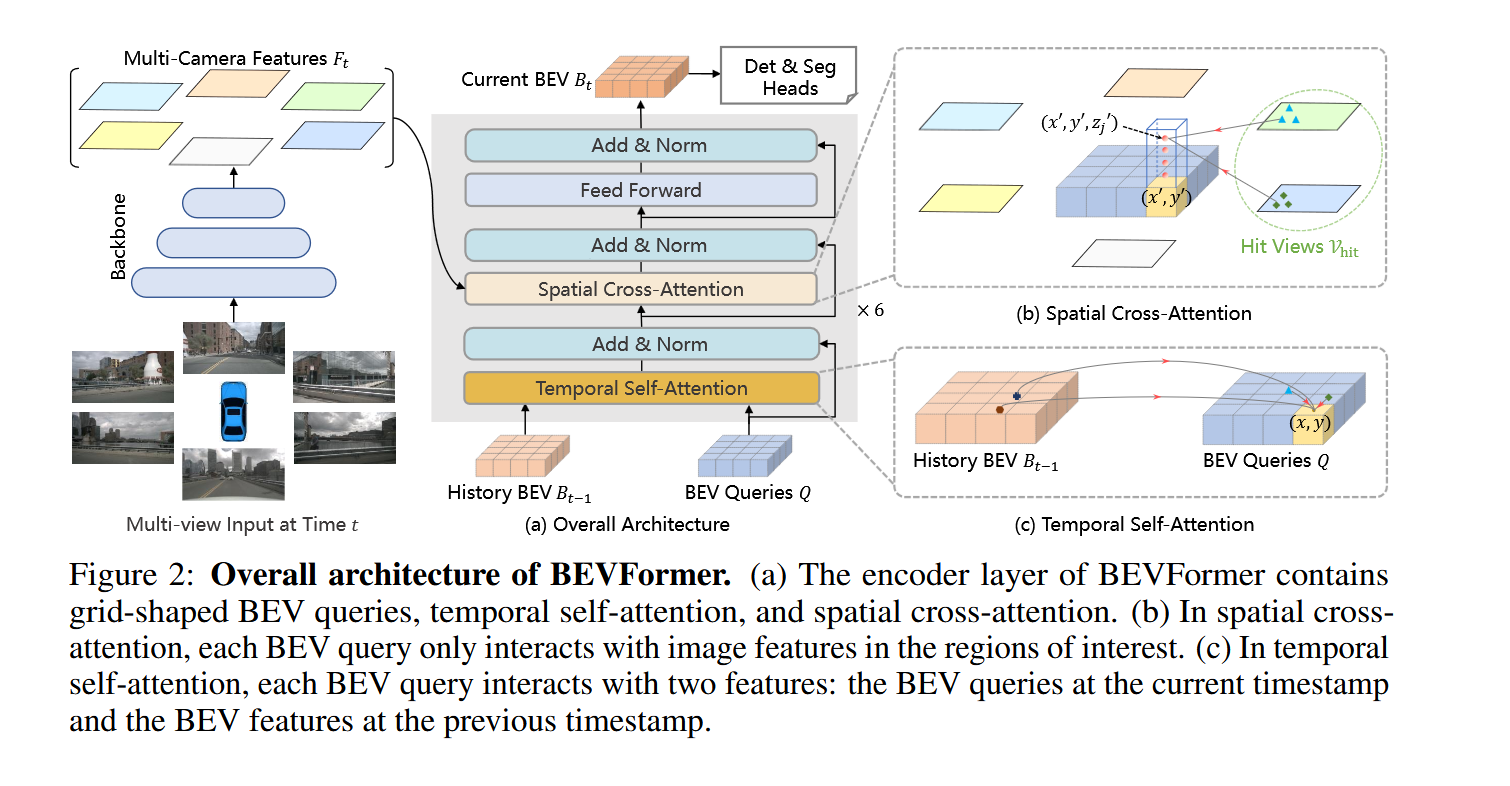

In [ ]:
# from 
display(Image("reportFigs/bevformer.png"))

Unlike HRMapNet, BEVFormer keeps history of BEV (bird's-eye view) features (thus the temporal attn unit in the picture.) HRMapNet's authors claim that their approach is much more efficient in memory:
> Take the Boston map in nuScenes dataset [1] as
an example, BEV features require over 11 GB memory in NMP [45]. By contrast,
we propose to maintain a low-cost historical rasterized map for vectorized map
perception, which takes only 120 MB memory for the same Boston map.

This is well-expected since raster maps are (perhaps, sparse) tensors of shape $N\times H \times W $ 
(where $N$ is a number of classes, i.e. 3 in all the examples: lane divider, road boundary and pedestrian crossing), 
whereas BEV feature maps are (likely non-sparse) tensors of shape $Ch \times H \times W$,
where $Ch$ equals 256 in the experiments BEVFormer authors run (sect. 4.2 of https://arxiv.org/pdf/2203.17270) 
(BTW, $\frac {256} 3 \times 120 MB \approx 11GB$, so this simple intuition adds up.)

### Why rasterize? 

As I've said, HRMapNet is a plugin that uses other nets. To predict new parts of the map it uses MapTR, a predictor of *vector* maps. So, why not keep a global map as a vector one, too?

I didn't find a definitive answer in the paper. Let's see what would architectually change 
if maps were left **un**-rasterized:
1. Updating the global vector map is even easier (just adding vertices and perhaps merging shapes),
getting a local map might be not very trivial as we would need to somehow check all the objects in the map for intersection with the current local fragment, which is very clumsy; 
2. Using a vector local map in cross-attention is not a problem, too: we embed only vertices and initialize queries with them (since attn is quadratic in number of keys, this might even speed up this unit);
3. The map encoder and aggregation units, however, need a map to be an $N\times H \times W$ tensor 
(where extracted features are of shape $... \times H \times W$) to keep their simple convolutional architecture.
I suppose, if we wanted to keep the global map as a vector map, these two units would have needed to rasterize it anyway. I suppose, the authors had no reason to perform rasterization on every step and decided not to
bother and pass a rasterized map to every unit.

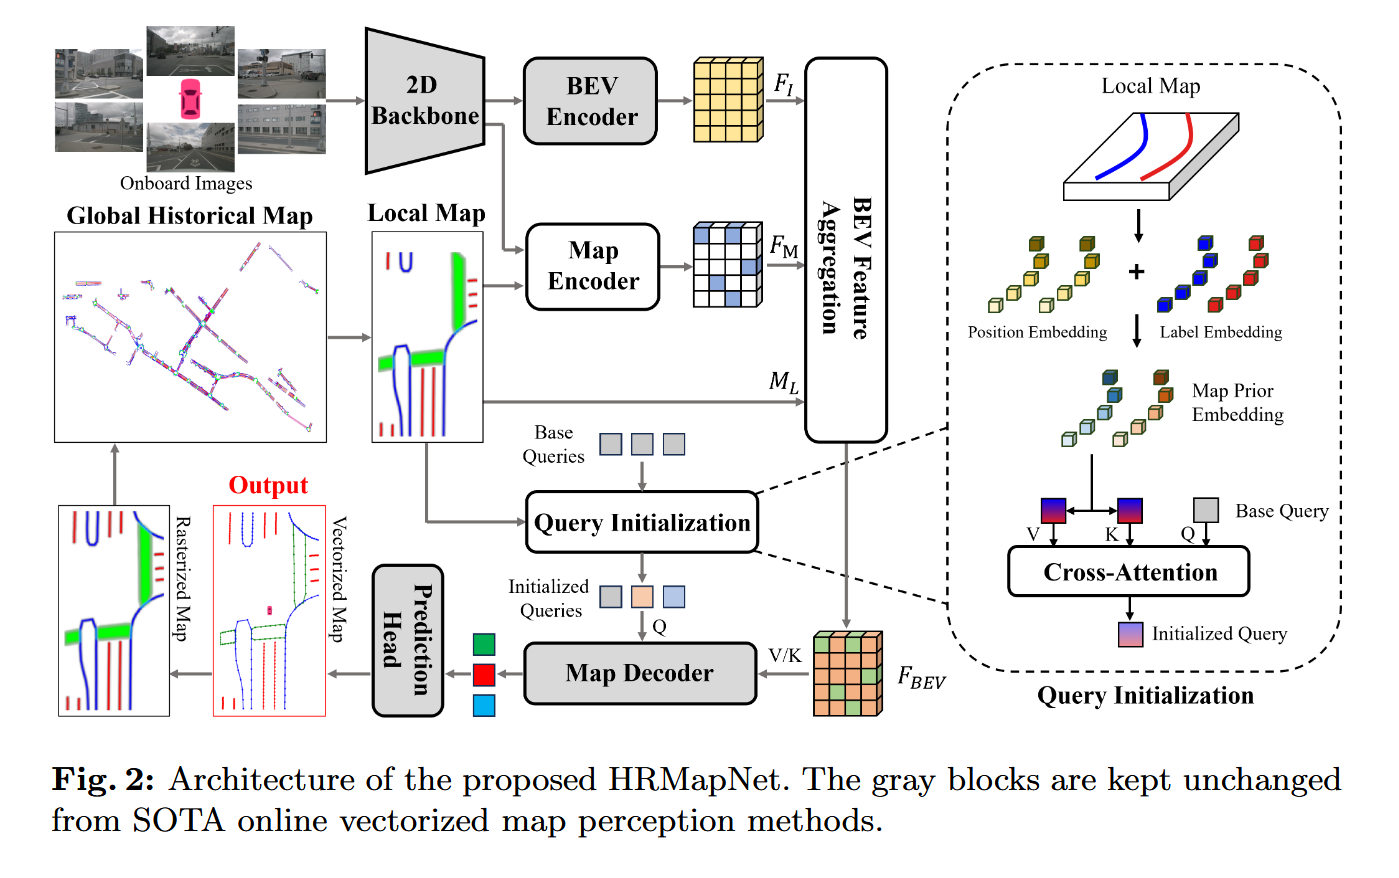

In [13]:
display(Image('reportFigs/fig2_clean.png'))

I suppose, all these minor inconveniences advocate for rasterization quite well. 

Also, I can't think of any scaling issues raster images might run into when the net starts keeping bigger global maps (since the rasterized map is sparse). 
Moreover, raster images can be easily obtained from plenty of formats, unlike vector images.
This means that raster global maps are easier to precompute using "open-source" maps, which may be of various formats.

Finally, a rasterized map does not yield any "ambiguity" which MapTR authors are fighting with permutations, which is comforting to know, since this ambiguity seems rather hurtful (sect. 4.2 from https://arxiv.org/pdf/2208.14437).

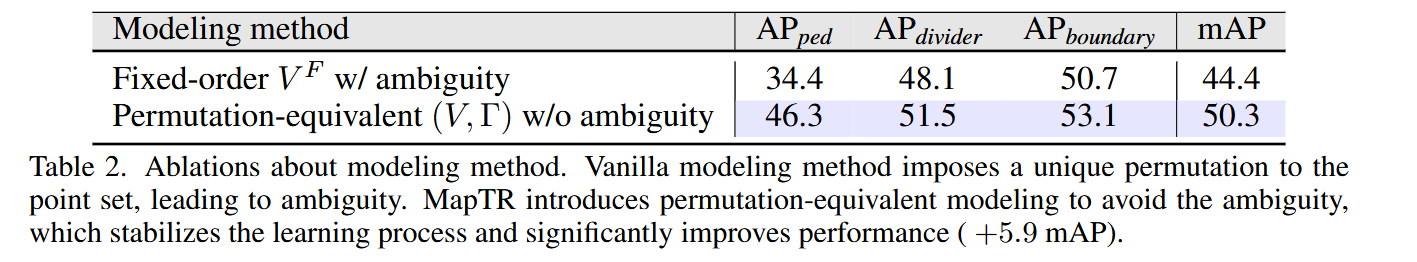

In [14]:
display(Image("reportFigs/permut.png"))

### Let's take a step back...
and ask ourselves again, what are we doing.

How does retrieving a global map from sensors help automated vehicles? For example, if a self-driving is self-driving somewhere, it should have some sort of a map already, how else would it know where it is going?

So, I suppose the use-case of this net in self-driving cars is the following: the car has an offline global map with lane separators, pedestrian crossings, etc. marked in it. This offline map directs the car and at the same time gives prior information to the net, which builds a more elaborate map, adding details absent in the offline map, like roadwoark, collisions and, of course, pedestrians. 

A much more direct application this technology would have for robots, for example, solving mazes or sprinting or doing any other activity that has a very clear direction without any sort of prior map.

## 1. Experiments

Wasn't able to install without GPU :(

## 2. The Architecture

Architecture of the net is well-drawn in figure 2 of the paper. Here it is (sect 2.2 of https://arxiv.org/pdf/2409.00620)

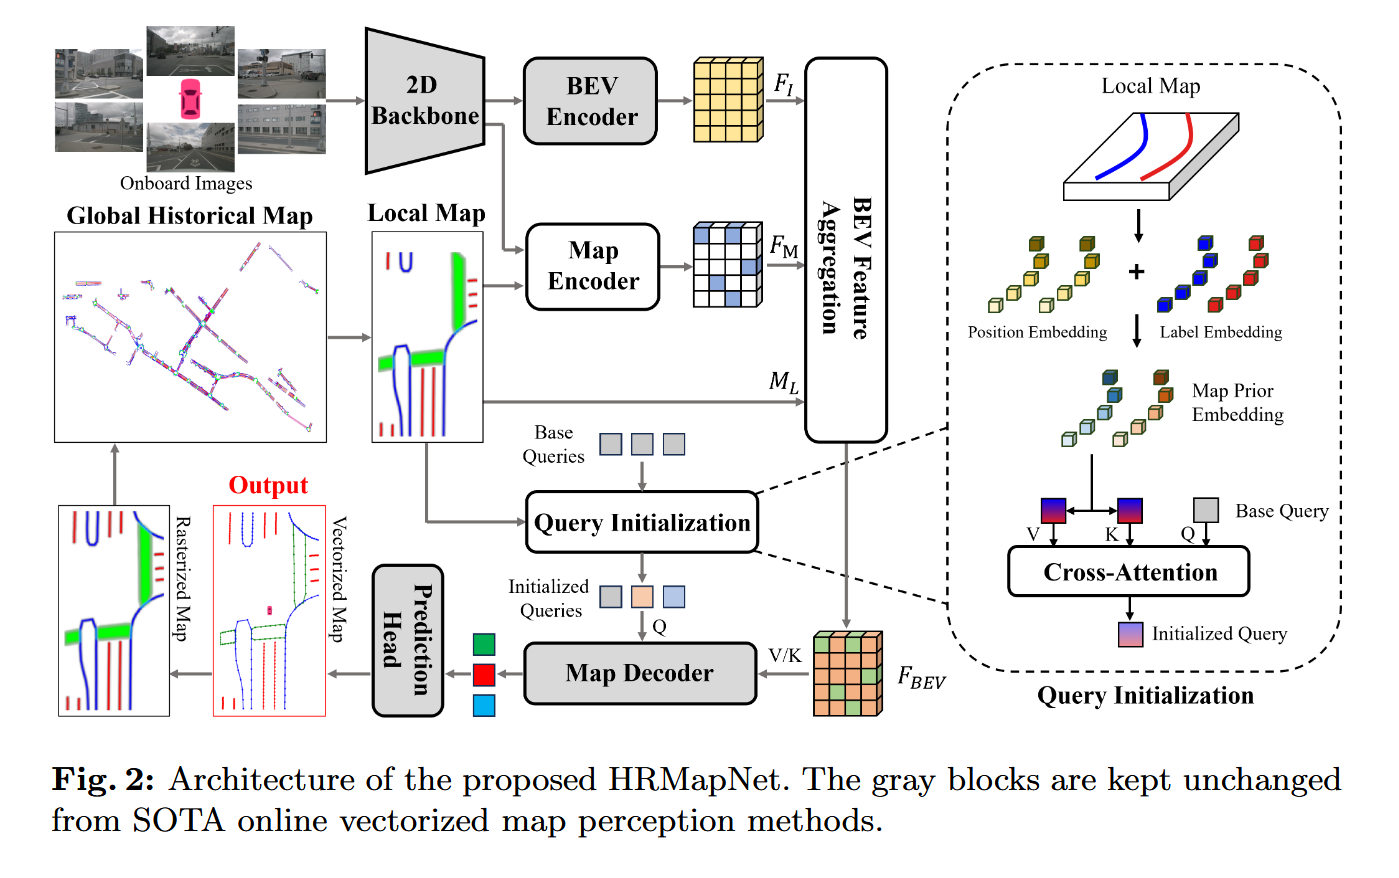

In [8]:
display(Image('reportFigs/fig2_clean.png'))

The particular instances of this model are in `HRMapNet\projects\configs\hrmapnet\` folder.
I will take the `HRMapNet\projects\configs\hrmapnet\hrmapnet_maptrv2_nusc_r50_110ep.py` model to be specific.

So, as I've already said, HRMapNet is plugged into MapTRv2 


In [2]:
# lines 80, 81
model = dict(
    type='MapTRv2',
    # ...
)

The `MapTRv2` class is defined in `projects\mmdet3d_plugin\maptr\detectors\maptrv2.py`.

Now, let's approach this beast carefully, step by step.

### Step 1. The Underlying DETR

Let's see what it is based on by removing HRMapNet's main novelty, i.e. the use of a historical map as a prior for new outputs:
>In this paper, we want to underscore the crucial role of a historical map

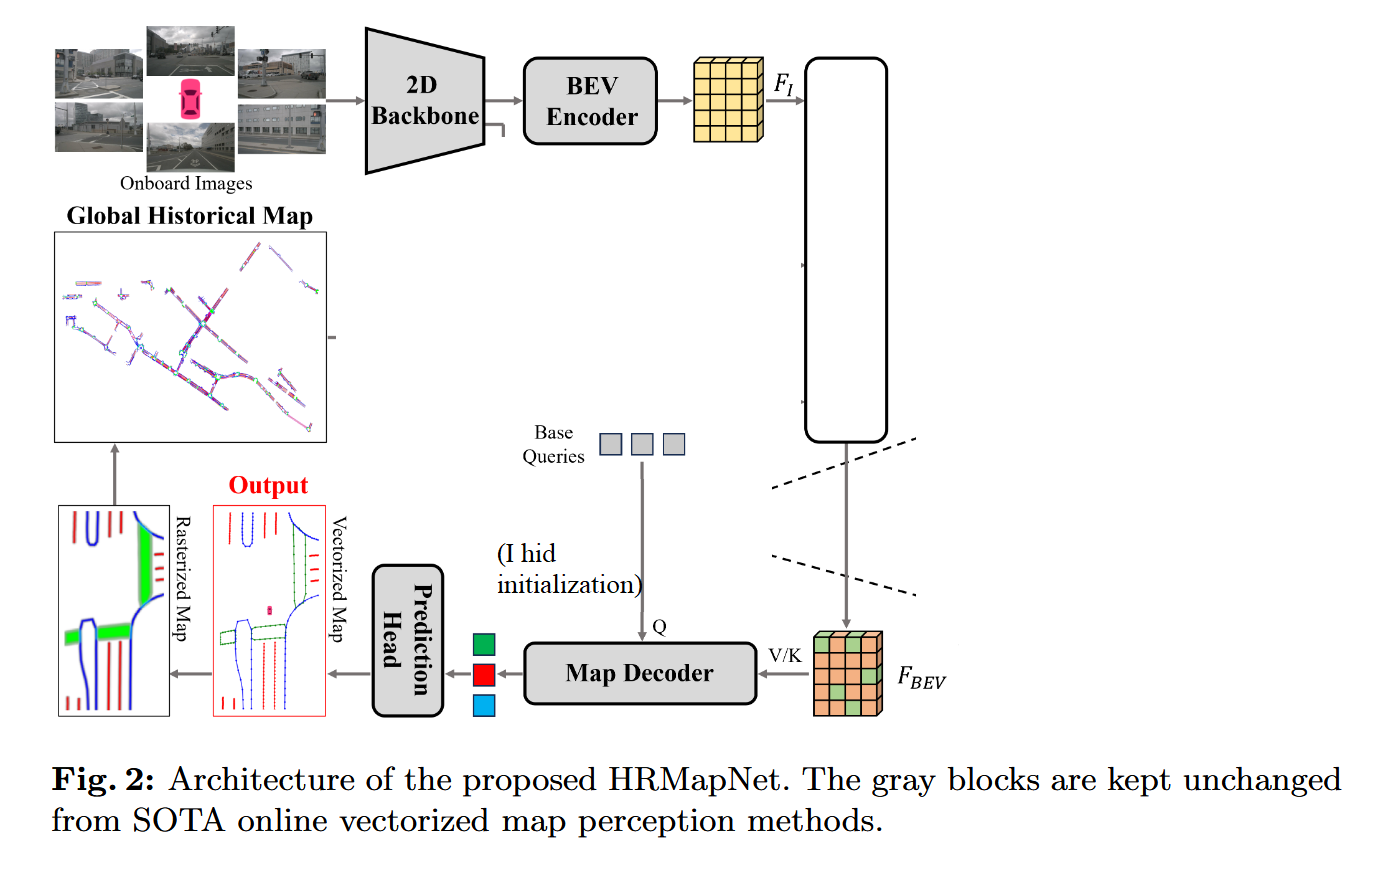

In [9]:
display(Image('reportFigs/fig2_detr.png'))

Well, what is left is a very simple encoder-decoder architecture, which highly resembles the well-known DETR.

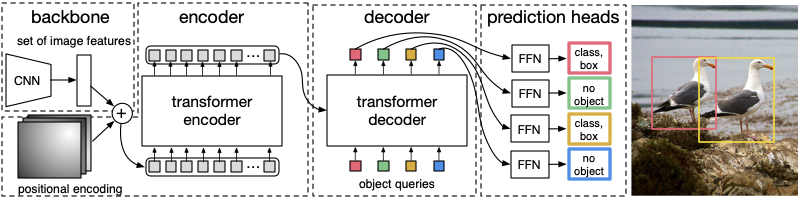

In [10]:
display(Image("reportFigs/detr.png"))

Let's take a closer look at the gray bubbles to be sure that this is DETR.


#### Backbone 

> Various methods [15, 22, 23, 28, 31] have been proposed to transform features
from perspective view to BEV space, serving as a fundamental module in map
perception. For example, MapTRv2 [26] utilizes BEVPoolv2 [15] to acquire BEV
features $F_I \in R^{H\times W \times C}$ , where C is the number of feature channels. We keep
this module unchanged...

And indeed, the backbone is a simple ResNet (the `img_backbone` param of the `model`).



In [3]:
# lines 86, 87
img_backbone=dict(
        type='ResNet',
        # ...
)



It is invoked in the `MapTRv2.extract_img_feat` member function and its mixed precision counterpart `MapTRv2.extract_feat`,
which do not do much else beside invoking (they run some ifs and reshape stuff.)

All in all, the member function takes several batches of images, total size $B \times N \times C \times H \times W$, 
and returns a list of features, total shape $\frac B Q \times Q \times N \times C' \times H' \times W'$ 
(where $Q$ is some performance parameter that defaults to 1 and thus is not really used.)

#### BEV Feature Extraction, Map Decoding and Prediction 

Further work is done by the `pts_bbox_head` parameter, which is an instance of `MapTRv2Head` class (`projects\mmdet3d_plugin\maptr\dense_heads\maptrv2_head.py`.)

In [ ]:
# lines 103-202 of config
pts_bbox_head=dict(
    type='MapTRv2Head',
    # ...
    transformer=dict(
        type='MapTRPerceptionTransformer',
        # ...
        map_encoder=dict( # this param is absent in the original MapTR 
                            # as the name implies, it is the Map Encoder,
                            # suggested by the HRMapNet authors. Thus, not relevant
                            # for now. Just note that it is here, too
            type='BEVFormerEncoder', # ...
        ),
        encoder=dict(
            type='LSSTransform',
            # ...
        decoder=dict(
            type='MapTRDecoder', # ...
            )
        ),
    ),
    positional_encoding=dict(
        type='LearnedPositionalEncoding', # ...
    ),
    # ...
)



The name `pts_bbox_head` is not clear, 
since, the MapTR article gave me an impression they are trying to avoid bounding boxes (sect. 1 of https://arxiv.org/pdf/2208.14437):
 > Different from object detection in which objects can be easily geometrically abstracted as bounding
box, vectorized map elements have more dynamic shapes. 

I suppose, they actually mean that the "big polygonal" bbox is obtained from small regular ones. Actually, this seems reasonable and I do not see any alternatives.

##### BEV features extraction

BEV features are extracted by the `pts_bbox_head.transformer` member (this is a member of the base `DETRHead` class),
an instance of `MapTRPerceptionTransformer` class (`projects\mmdet3d_plugin\maptr\modules\transformer.py`),
in its member function `pts_bbox_head.transformer.get_bev_features`,
which calls an appropriate encoder, an LSS Transformer in our case (specified in `pts_bbox_head.transformer.encoder`).
The original paper on HRMapNet does not justify this choice anyhow, and it is not consistent:
some other configurations use other encoders.
MapTR paper simply mentions that 
it is compatible with LSS and runs some tests with it 
(sect. 4.2 in https://arxiv.org/pdf/2208.14437).

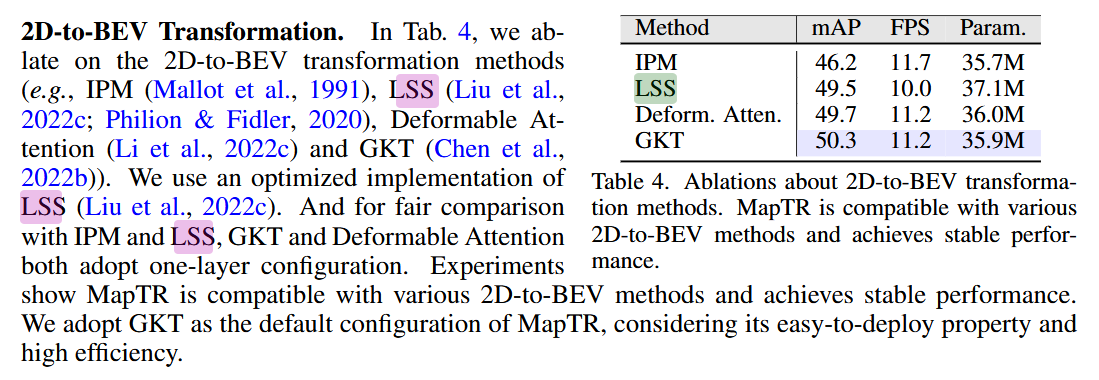

In [8]:
display(Image("reportFigs/lss_tests.png"))

##### Map Decoder and the Prediction Head

BEV features are then decoded with `pts_bbox_head.transformer.decoder` member,
an instance of `MapTRDecoder` class 
(`projects\mmdet3d_plugin\maptr\modules\decoder.py`).

In [ ]:
 # lines 166-202 of config
decoder=dict(
    type='MapTRDecoder',
    num_layers=6,
    # ...
    transformerlayers=dict(
        type='DecoupledDetrTransformerDecoderLayer',
        # ...
        attn_cfgs=[
            dict(
                type='MultiheadAttention',
                # ...
            ),
            dict(
                type='MultiheadAttention',
                # ...
            ),
            dict(
                type='CustomMSDeformableAttention',
                # ...
            ),
        ],
        # ...
        operation_order=('self_attn', 'norm', 'self_attn', 'norm', 'cross_attn', 'norm',
                            'ffn', 'norm')
    )
)

The decoder simply applies the `DecoupledDetrTransformerDecoderLayer` 6 times (given by `num_layers`; see https://github.com/open-mmlab/mmcv/blob/f19d3e771c211ca20e3f8ab838e3851cae263035/mmcv/cnn/bricks/transformer.py#L889).
The result is passed the prediction head, which is just 2 
(default from https://github.com/open-mmlab/mmdetection/blob/main/mmdet/models/dense_heads/detr_head.py)
fully-connected layers, just like in the original DETR architecture (caption to fig. 2 in https://arxiv.org/pdf/2005.12872)
> We pass each output embedding of the
decoder to a shared feed forward network (FFN) that predicts either a detection (class
and bounding box) or a “no object” class.

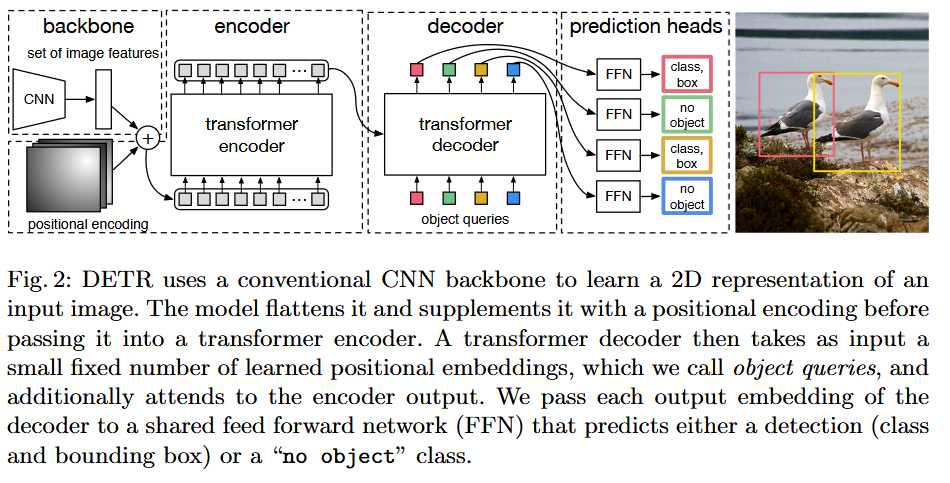

In [14]:
display(Image("reportFigs/detr_w_caption.png"))

`pts_bbox_head.transformer` returns the results of the prediction head.
These are not bboxes yet, first they should pass through the `pts_bbox_head.bbox_coder`, 
an instance of `MapTRNMSFreeCoder` class (`projects\mmdet3d_plugin\core\bbox\coders\nms_free_coder.py`).
I didn't find any interesting work done there, mostly it's just denormalizing and rescaling and so on.

In [ ]:
# lines 391-406 of projects\mmdet3d_plugin\maptr\detectors\maptrv2.py
def simple_test_pts(self, x, lidar_feat, img_metas, local_map=None, rescale=False):
    """Test function"""
    outs = self.pts_bbox_head(x, lidar_feat, img_metas, local_map=local_map)

    bbox_list = self.pts_bbox_head.get_bboxes(
        outs, img_metas, rescale=rescale)
    
    bbox_results = [
        self.pred2result(bboxes, scores, labels, pts)
        for bboxes, scores, labels, pts in bbox_list
    ]

    if self.global_map is not None and self.update_map:
        new_map = self.pts_bbox_head.get_pred_mask(outs) # Generate bboxes from bbox head predictions.
        self.update_global_map(img_metas, new_map, 'val')
    return outs['bev_embed'], bbox_results

So, the bbox prediction indeed follows the DETR paradigm, which concludes this step.
In the next step we will see how these bboxes are used.

### Step 2. The Global Map

#### Local Map Extraction

#### Global Map Update

### Finally, 
let's get the sizes of the tensors out of the way.
The dimensions are listed right at the top of the configuration file. Here they are (lines 48-57)

In [ ]:
# lines 48-56
_dim_ = 256
_pos_dim_ = _dim_ // 2
_ffn_dim_ = _dim_ * 2
_num_levels_ = 1
bev_h_ = 200
bev_w_ = 100
queue_length = 1  # each sequence contains `queue_length` frames.

## 3. Train

`grep -r` did not reveal `wandb` support.

## 4. Visualize

## 5. Improve!